In [112]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
from numpy.linalg import norm

from functools import partial

from PIL import Image
from skimage import transform


In [113]:
def zero_noise(dx):
    return 0

def uniform(a, b, dx):
    return np.random.uniform(a, b, size=dx.shape)

def percent_noise(dx, alpha=2):
    return np.random.uniform(-alpha/2*dx, +alpha/2*dx)
    

'''
Returns an approximation of the path that a drone would take given an array of change in position updates
DELTAS represents the change in position for each step along the path
NOISE_FN applies noise to each path update, causing a deviation compared to the true path, achieve by 
simply summing up the elements of DELTAS
path[0] represents the location of the drone after update deltas[0],
unless prepend_zero == True, in which case it is [0, 0].
'''
def simulate_input(deltas, noise_fn=zero_noise, prepend_zero=True, astype=int):
    path = np.zeros(deltas.shape)
    for i in range(len(path)):
        path[i] = path[i-1] + deltas[i] + noise_fn(deltas[i])
        
    if prepend_zero:
        return np.concatenate((np.zeros((1,2)), path), axis=0).astype(astype)
    else:
        return path.astype(astype)

def wide_uturn(leg=10):
    ones = np.ones((leg,1));
    zeros = np.zeros((leg,1));
    
    leg1 = np.hstack((ones, zeros))
    leg2 = np.hstack((zeros, ones))
    leg3 = np.hstack((-ones, zeros))
    return np.concatenate((leg1, leg2, leg3), axis=0)

def s_turn(short_leg=5):
    ones = np.ones((short_leg,1));
    zeros = np.zeros((short_leg,1));
    
    leg1 = np.hstack((ones, zeros))
    leg2 = np.hstack((zeros*2, -ones*2))
    leg3 = np.hstack((ones, zeros))
    return np.concatenate((leg1, leg2, leg3), axis=0)

In [114]:
def imread(path, grayscale=False):
    if grayscale:
        img = np.array(Image.open(path).convert('L'))
    else:
        img = np.array(Image.open(path))
    
    return np.swapaxes(img, 0, 1)

def imshow(img, ax=None, grayscale=False, **kwargs):
    if grayscale:
        kwargs['cmap'] = 'gray'
        kwargs['vmin'] = 0
        kwargs['vmax'] = 255
    
    img = np.swapaxes(img, 0, 1) # Convert back to (y,x)
    if img.ndim == 3: # RBG color
        if ax == None:
            plt.imshow(img, **kwargs)
        else:
            ax.imshow(img, **kwargs)
    else:
        if ax == None:
            plt.imshow(img, **kwargs)
        else:
            ax.imshow(img, **kwargs)

'''
    Returns a square slice of IMG with shape RADIUS*2 X RADIUS*2 
    with the point (X_CENTER, Y_CENTER) in the middle. 
'''
def sample_square(img, x_center, y_center, radius):
    return img[x_center - radius : x_center + radius, y_center - radius : y_center + radius]


'''
    If X_REF and Y_REF are NONE, TEST_IMG and REF_IMG must have same shape. 
    Can be grayscale n x m x 1 or color n x m x 3
    
    If X_REF and Y_REF are not NONE, take a slice of REF_IMG with 
    the point (X_REF, Y_REF) at the center that is the same shape as TEST_IMG.
    TEST_IMG must be a square.
    
    Returns the MSE difference between TEST_IMG and REF_IMG i.e insensitive to the size of the images
'''
def compare_images(test_img, ref_img, x_ref=None, y_ref=None):
    if x_ref == None and y_ref == None:
        assert test_img.shape == ref_img.shape
    elif x_ref != None and y_ref != None:
        # Take a slice from REF_IMG rather than the whole thing
        ref_img = sample_square(ref_img, x_ref, y_ref, test_img.shape[0] // 2)
    else:
        raise ValueError("X_REF and Y_REF must both be either None or not None.")
        
    # Sum of squares difference
    mse = np.sum(np.square(test_img - ref_img)) / ref_img.size
    return mse

'''
Sample a slice of REF_IMG that is the same shape as TEST_IMG, centered at each location in SEARCH_COORDS.

Return the (x,y) pair that is centered at the slice of REF_IMG that best matches TEST_IMG.
'''
def search(search_coords, test_img, ref_img, threshold=None):
    best_match = float('inf')
    best_coords = (None, None)
    for loc in search_coords:
#         print(loc)
        match = compare_images(test_img, ref_img, *loc)
        if threshold != None and match < threshold:
            return (match, loc)
        if match < best_match:
            best_match = match
            best_coords = loc
    return (best_match, best_coords)

def taxicab_norm(x1, y1, x2, y2):
    return abs(x1 - x2) + abs(y1 - y2)

def euclid_norm(x1, y1, x2, y2):
    return np.sqrt(np.square(x1 - x2) + np.square(y1 - y2))

'''
Returns the locus of points a certain distance R from (X,Y)
'''
def circular_path(x, y, r, norm_fn=taxicab_norm, line_width=1):
    x, y = int(x), int(y)
    path = []
    for xi in range(x-r, x+r+1):
        for yi in range(y-r, y+r+1):
            d = norm_fn(x, y, xi, yi)
            if abs(d-r) < float(line_width)/2:
                path.append((xi, yi))
    return np.array(path)

def spiral_path(x, y, max_r, **kwargs):
    path = []
    for r in range(max_r+1):
        path.extend(circular_path(x, y, r, **kwargs))
    return np.array(path)

In [115]:
import time

from scipy.special import expit
def derive_confidence(mse):
    return 1 - expit(mse)

# Set up some initial conditions and parameters
start_pos = (1500,850)
search_radius = 40
spiral = spiral_path(0, 0, search_radius) # TODO fix this
FIELD_OF_VIEW = 100
deltas = np.vstack((np.vstack([s_turn(1) for _ in range(3)]), wide_uturn(3)))
deltas = deltas[:100] # just a small slice
deltas *= 25
deltas

array([[ 25.,   0.],
       [  0., -50.],
       [ 25.,   0.],
       [ 25.,   0.],
       [  0., -50.],
       [ 25.,   0.],
       [ 25.,   0.],
       [  0., -50.],
       [ 25.,   0.],
       [ 25.,   0.],
       [ 25.,   0.],
       [ 25.,   0.],
       [  0.,  25.],
       [  0.,  25.],
       [  0.,  25.],
       [-25.,   0.],
       [-25.,   0.],
       [-25.,   0.]])

In [126]:
# Load the map
gs = False
ref_img = imread('manhattan.jpg', gs) # The full reference image
# ref_img = sample_square(ref_img, 1000, 1000, 200) # crop it a bit

# Simulate some paths
path_true = start_pos + simulate_input(deltas, prepend_zero=True);
path_est_inert = start_pos + simulate_input(deltas, partial(percent_noise, 1));
end_pos = path_true[-1]

# Apply image recognition to improve estimate
path_est_img = []
weights = []
for i, (true_loc, inert_est_loc) in enumerate(zip(path_true, path_est_inert)):
#     if not (5 <= i <= 10):
#         continue
# #     if i != 10:
# #         continue
    # Use image recognition to come up with an alternate estimate
    search_path = spiral + inert_est_loc
#     search_path = spiral_path(*inert_est_loc, max_r=search_radius, norm_fn=euclid_norm)
    img = sample_square(ref_img, true_loc[0], true_loc[1], FIELD_OF_VIEW)
    
    start = time.time()
    mse, img_est = search(search_path, img, ref_img, threshold=None)
    end = time.time()

    confidence = derive_confidence(mse)
    path_est_img.append(img_est)
    weights.append(confidence)
    
    print(i, end - start, true_loc, inert_est_loc, confidence, img_est)


path_est_img = np.array(path_est_img)
weights = np.array(weights)

0 0.4739518165588379 [1500  850] [1500  850] 0.5 [1500  850]
1 0.43755006790161133 [1525  850] [1528  850] 0.5 [1525  850]
2 0.41762304306030273 [1525  800] [1528  818] 0.5 [1525  800]
3 0.4441261291503906 [1550  800] [1543  818] 0.5 [1550  800]
4 0.43968772888183594 [1575  800] [1576  818] 0.5 [1575  800]
5 0.4418671131134033 [1575  750] [1576  781] 0.5 [1575  750]
6 0.4232313632965088 [1600  750] [1596  781] 0.5 [1600  750]
7 0.41120290756225586 [1625  750] [1613  781] 0.0 [1623  751]
8 0.40921902656555176 [1625  700] [1613  735] 0.0 [1620  702]
9 0.40805888175964355 [1650  700] [1628  735] 0.0 [1636  703]
10 0.41765618324279785 [1675  700] [1665  735] 0.0 [1671  701]
11 0.41084885597229004 [1700  700] [1678  735] 0.0 [1686  703]
12 0.4076969623565674 [1725  700] [1714  735] 0.0 [1720  701]
13 0.432758092880249 [1725  725] [1714  769] 0.0 [1715  730]
14 0.43031978607177734 [1725  750] [1714  801] 0.0 [1717  764]
15 0.41894102096557617 [1725  775] [1714  821] 0.0 [1718  785]
16 0.4160

In [127]:
def correct_estimate(inert_est, img_est, confidence=0.5, astype=int):
    return ((1-confidence) * inert_est + confidence * img_est).astype(astype)
    
# def correct_estimate(inert_est, img_est, confidence=0.5, astype=int):
#     term1 = (1-confidence) * inert_est 
#     term2 = confidence * img_est
#     return (term1 + term2).astype(astype)

In [128]:
# Combine the estimates from inertial navigation and image recognition
path_est = correct_estimate(path_est_inert, path_est_img, np.tile(weights, (2,1)).T)

In [129]:
xlim = path_true.min(axis=0)[0] - FIELD_OF_VIEW//2, path_true.max(axis=0)[0] + FIELD_OF_VIEW//2
ylim = path_true.min(axis=0)[1] - FIELD_OF_VIEW//2, path_true.max(axis=0)[1] + FIELD_OF_VIEW//2
xlim, ylim

# xlim = end_pos[0] - FIELD_OF_VIEW//2, end_pos[0] + FIELD_OF_VIEW//2
# ylim = end_pos[1] - FIELD_OF_VIEW//2, end_pos[1] + FIELD_OF_VIEW//2

((1450, 1775), (650, 900))

(array([1650,  775]), array([1632,  821]), array([1632,  821]))

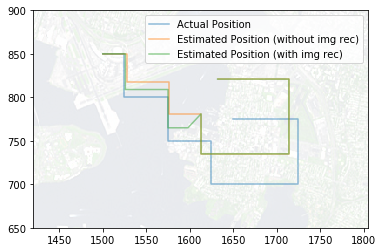

In [131]:
# Plot the results
fig, ax = plt.subplots(1,1)
 
imshow(ref_img, ax, gs, alpha=.1) # crop it a bit
plt.plot(path_true[:,0], path_true[:,1], alpha=.5, label="Actual Position")
plt.plot(path_est_inert[:,0], path_est_inert[:,1],  alpha=.5, label="Estimated Position (without img rec)")
plt.plot(path_est[:,0], path_est[:,1],  alpha=.5, label="Estimated Position (with img rec)")
plt.axis('equal')
plt.ylim(ylim)
plt.xlim(xlim)
plt.legend()
path_true[-1], path_est_inert[-1], path_est[-1]